I expect that pseudobulk should be respected in this framework. In this notebook  I inspect if Sergio's simulation of many cells converge to something.

To this extend, I run Sergio for only one cell type

In [14]:
import numpy as np
import pandas as pd
from SERGIO.sergio import sergio
from SERGIO.utils import convert_interaction_net_to_networkx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from scipy.stats import ttest_rel

In [15]:
path = 'data_sets/De-noised_100G_9T_300cPerT_4_DS1/'
input_file_targets=  path + 'Interaction_cID_4.txt'
input_file_regs= path + 'Regs_cID_4.txt'

read the topology files

In [11]:

def file_reader(filename):
    with open(filename) as f:
        data = []
        reader = csv.reader(f, delimiter="\t")
        for line in reader:
            data+=[line[0].split(',')]
    return data
input_regs = file_reader(input_file_regs)
input_targets = file_reader(input_file_targets)
input_regs = np.asarray(input_regs,dtype = float)

consider only one cell type

In [4]:
def run_sergio_1ct(input_regs,input_targets,number_sc = 5000):
    n_MR, n_celltypes = np.shape(input_regs)
    n_celltypes+=-1
    n_reg_genes = len(input_taregts)
    n_celltypes = 1
    sim = sergio(number_genes=n_MR+n_reg_genes, number_bins = n_celltypes,number_sc =number_sc , noise_params = 1, decays=0.8, sampling_state=15, noise_type='dpd')
    sim.build_graph_array(input_taregts = input_taregts, input_regs= np.array(input_regs)[:,:1+n_celltypes], shared_coop_state=2)
    sim.simulate()
    expr = sim.getExpressions()
    expr_clean = np.concatenate(expr, axis = 1)
    return expr_clean
%time expr1 = run_sergio_1ct(input_regs,input_targets)
expr2 = run_sergio_1ct(input_regs,input_targets)

Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level
CPU times: user 6min 15s, sys: 2.17 s, total: 6min 17s
Wall time: 6min 18s
Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level


[(12, 4.209436981430113e-23),
 (67, 8.652711680040609e-20),
 (30, 5.371895294347648e-16),
 (51, 7.117060497358179e-16),
 (22, 5.547717936049872e-15),
 (8, 1.0769449676105778e-14),
 (65, 2.3133007470707982e-14),
 (60, 2.543581209764007e-12),
 (75, 4.953755463467727e-11),
 (15, 1.2298539284777535e-10),
 (21, 1.6787901989377108e-10),
 (11, 3.1662488563213947e-10),
 (34, 8.548776553113705e-09),
 (32, 9.139733389000502e-09),
 (48, 5.953196190737924e-08),
 (81, 9.061683816733802e-08),
 (5, 2.103962341437854e-07),
 (88, 4.800980246085713e-07),
 (54, 5.198430784559485e-07),
 (57, 6.718922742445543e-07),
 (69, 1.012263019946025e-06),
 (86, 3.958876914441801e-06),
 (99, 8.353038472942672e-06),
 (35, 1.1243841679734226e-05),
 (71, 1.7661837867111523e-05),
 (36, 3.166018274603131e-05),
 (39, 6.237604804739535e-05),
 (56, 0.00012333361280526575),
 (89, 0.00012727415875031983),
 (20, 0.00014867258062954832),
 (95, 0.00024315864560112672),
 (53, 0.0002582734629156486),
 (37, 0.0004145613719888473),
 

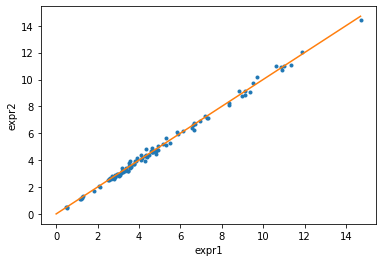

In [7]:
def compare_pseudobulk(expr1,expr2):
    plt.plot(expr1.mean(axis = 1),expr2.mean(axis = 1),'.')
    #list(zip(expr1.mean(axis = 1),expr2.mean(axis = 1)))

    M = max([expr1.mean(axis = 1).max(),expr2.mean(axis = 1).max()])
    plt.plot([0,M],[0,M])
    plt.xlabel('expr1')
    plt.ylabel('expr2')
    p_values = ttest_rel(expr1,expr2,axis = 1)[1]
    thr = 0.05
    return sorted(list(zip(np.arange(len(expr1))[p_values<thr],p_values[p_values<thr])),reverse=False,key= lambda x:x[1])#genes for which the null hypothesis is rejected
compare_pseudobulk(expr1,expr2)

<AxesSubplot:ylabel='Count'>

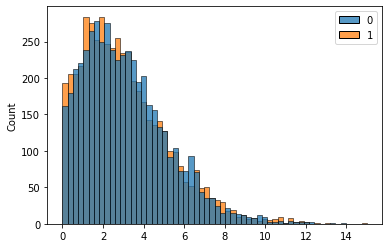

In [8]:
i = 90#gene to look at 
sns.histplot([expr1[i],expr2[i]])


## Perturbation simulation

In [99]:
crispri = np.ones(len(input_regs))
target_gene_idx = 0
crispri[target_gene_idx] = 0.1
target_gene = int(input_regs[target_gene_idx][0])
print('Perturbing gene',target_gene)
crispri = np.stack((np.array(input_regs)[:,0],crispri*np.array(input_regs)[:,1]),axis = 1)
expr_pert = run_sergio_1ct(crispri,input_taregts)


Perturbing gene 67
Start simulating new level
There are 4 genes to simulate in this layer
Done with current level
Start simulating new level
There are 6 genes to simulate in this layer
Done with current level
Start simulating new level
There are 90 genes to simulate in this layer
Done with current level


[(67, 1.6472195494727455e-267),
 (86, 1.3721788879711577e-42),
 (87, 2.7493118943542795e-28),
 (94, 9.375426767418233e-26),
 (63, 4.346426607578531e-20)]

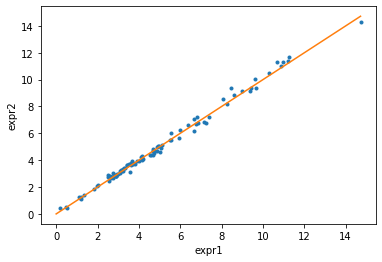

In [114]:
p_val_dict = dict(compare_pseudobulk(expr_pert,expr1))
sorted(p_val_dict.items(),reverse=False,key= lambda x:x[1])[:5]#show index and p-values of top 5 differentially expressed genes

<AxesSubplot:ylabel='Count'>

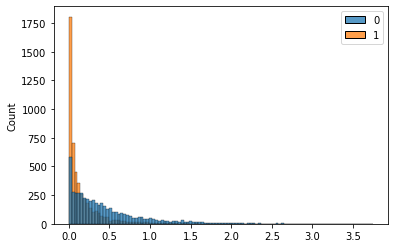

In [139]:
i = 67#target_gene #gene to look at 
sns.histplot([expr1[i],expr_pert[i]])

In [17]:
G = convert_interaction_net_to_networkx(input_file_targets)
#list(zip(*G.out_edges(67,data=False)))
sorted(list(G.neighbors(67)))

[52, 53, 54, 55, 60, 61, 63, 64, 70, 71, 74, 77, 80, 82, 86, 88, 98]

In [21]:
import networkx as nx

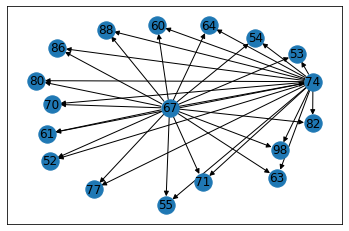

In [138]:
nx.draw_networkx(nx.ego_graph(G,67))

In [25]:
largest = max(nx.strongly_connected_components(G), key=len)
largest


100